In [902]:
import os
import pandas as pd
import json
import  matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

In [910]:
df=pd.read_csv("paris_traffic_top.csv")

In [911]:
#Convert timestamp to timestamp
df["timestamp"]=pd.to_datetime(df["timestamp"])
#Convert date to timestamp
df["date"]=pd.to_datetime(df["date"])

In [912]:
df["year"]=df["timestamp"].dt.year
df["week"]=df["timestamp"].dt.week

In [906]:
#Rearange columns
columns=df.columns[:2].append(df.columns[-2:].append(df.columns[2:-2]))
df=df[columns]

### Global Traffic Trends Prediction

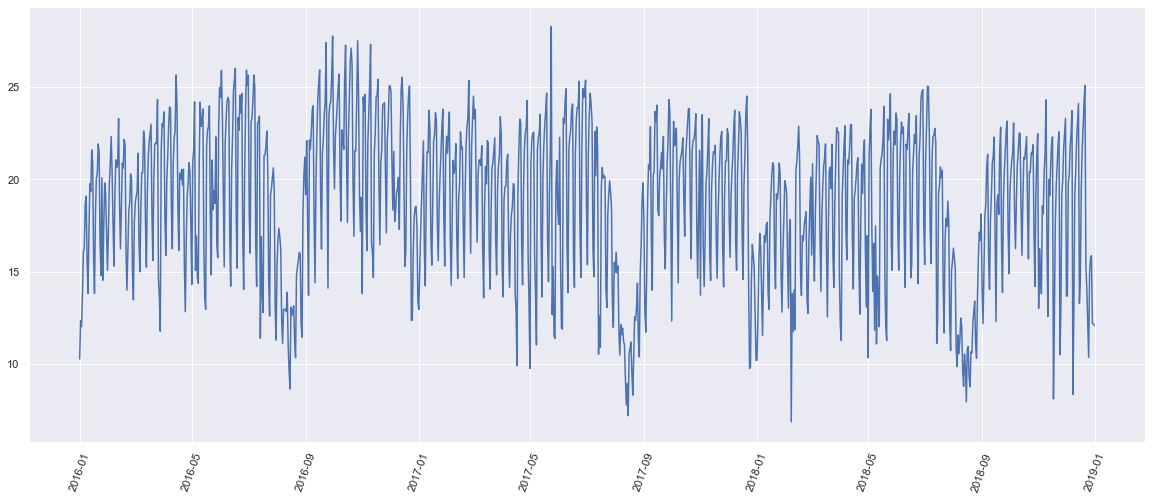

In [907]:
#Plot mean daily traffic rate

daily_means=df.groupby("date").mean()
fig,ax=plt.subplots(figsize=(20,8))
plt.xticks(rotation=70)
ax.plot(daily_means["occupation_rate"]);


In [908]:
#X Compute Moving average over 2 weeks
rolling=daily_means["occupation_rate"].rolling(window=15).mean()[15:]

### Smoothing traffic trends with moving averages

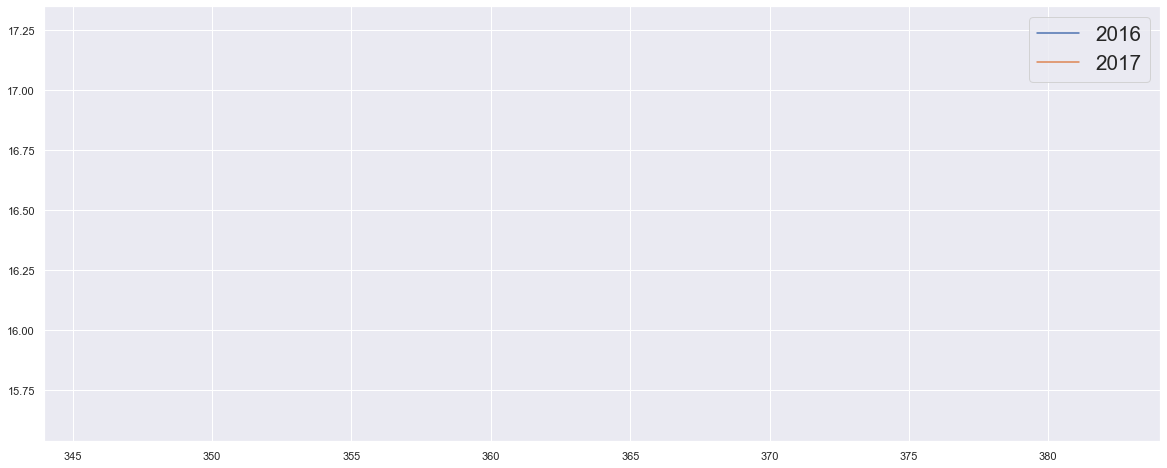

In [909]:
#Plot moving average
plt.figure(figsize=(20,8))
plt.plot(rolling[:365].values,label="2016")
plt.plot(rolling[365:730].values,label="2017")
plt.legend(fontsize="xx-large")

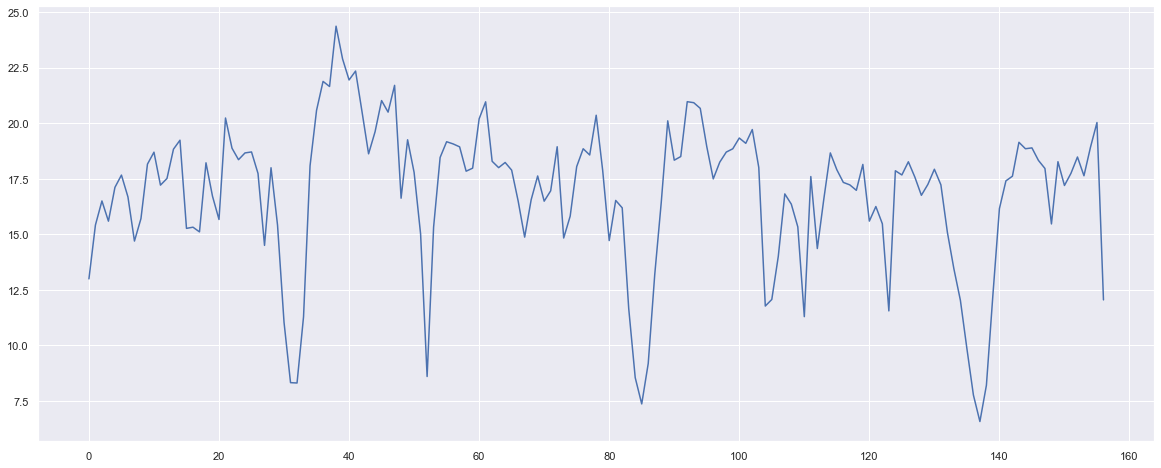

In [888]:
plt.subplots(figsize=(20,8))
plt.plot(df.groupby(["year","week"]).mean().reset_index()["occupation_rate"])

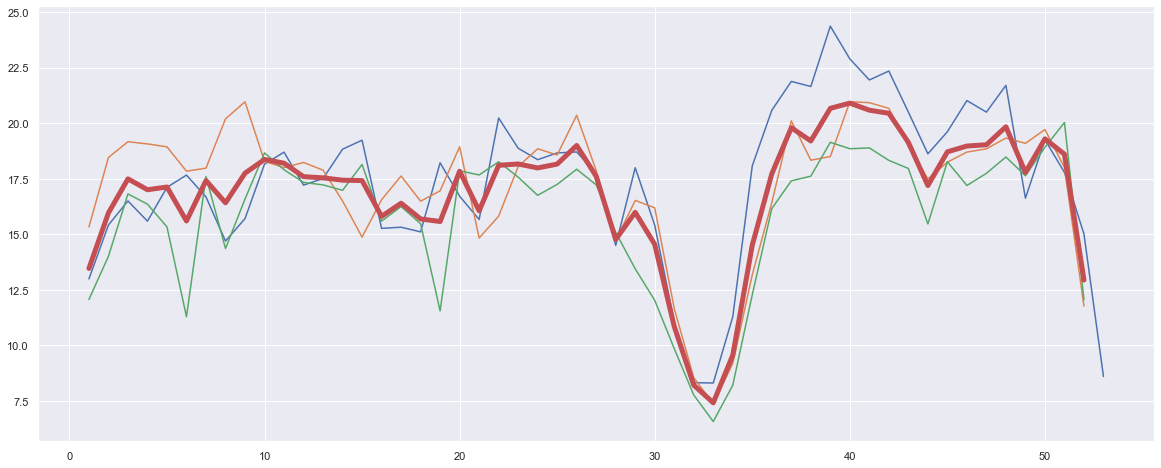

In [889]:
week_mean_2016=df[df["year"]==2016].groupby(["week"]).mean()["occupation_rate"]
week_mean_2017=df[df["year"]==2017].groupby(["week"]).mean()["occupation_rate"]
week_mean_2018=df[df["year"]==2018].groupby(["week"]).mean()["occupation_rate"]

plt.subplots(figsize=(20,8))
plt.plot(week_mean_2016)
plt.plot(week_mean_2017)
plt.plot(week_mean_2018)

week_mean_all=(week_mean_2016+week_mean_2017+week_mean_2018)/3
plt.plot(week_mean_all,linewidth=5.0)

### Forecasting average weekly traffic with moving average over yearly differences

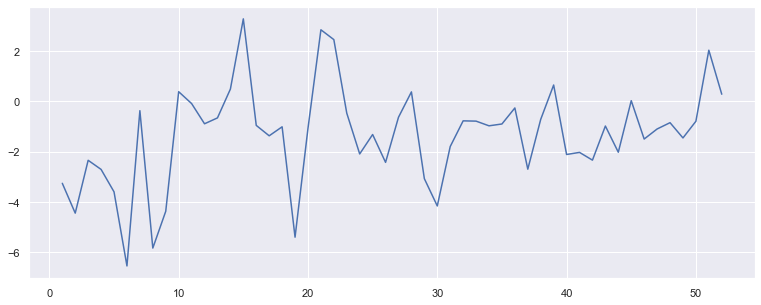

In [890]:
week_mean_diff=week_mean_2018-week_mean_2017
fig,ax=plt.subplots(figsize=(13,5));
plt.plot(week_mean_diff);

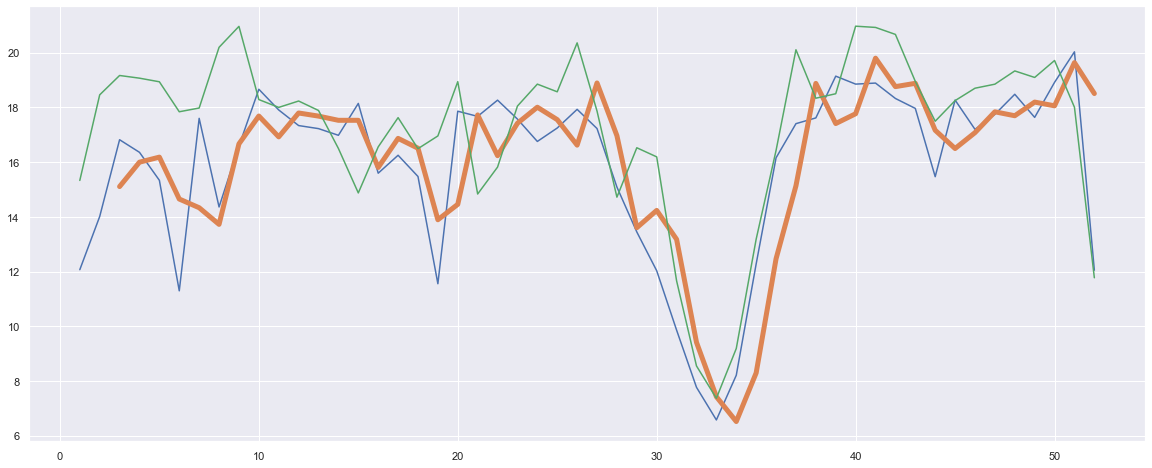

In [891]:
plt.subplots(figsize=(20,8))
plt.plot(week_mean_2018);
plt.plot(week_mean_diff.rolling(window=3).mean()+week_mean_2017.shift(),linewidth=5);
plt.plot(week_mean_2017);


### Forecasting daily traffic rates based on weekday segmentation

In [892]:
monday=df[df["weekday"]==0]
tuesday=df[df["weekday"]==1]
wednesday=df[df["weekday"]==2]
thursday=df[df["weekday"]==3]
friday=df[df["weekday"]==4]
saturday=df[df["weekday"]==5]
sunday=df[df["weekday"]==6]

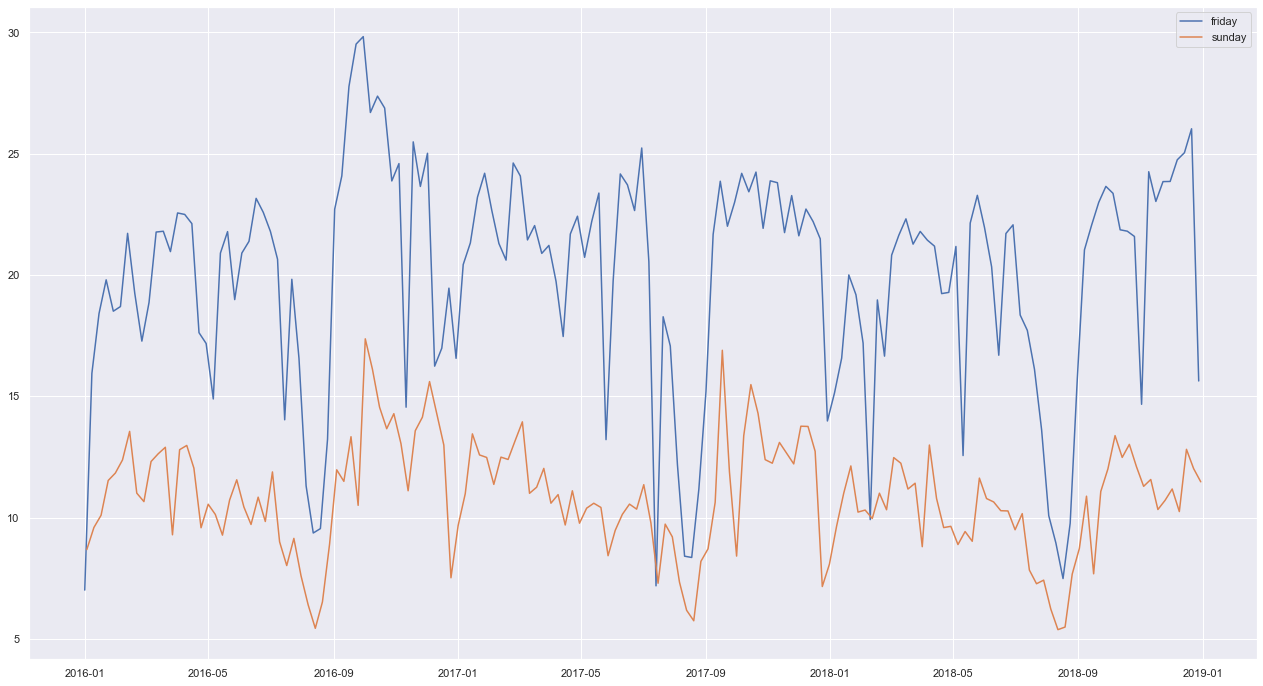

In [893]:
fig,ax=plt.subplots(figsize=(22,12))

#ax.plot(monday.groupby("date").mean()["occupation_rate"],label="monday")
#ax.plot(tuesday.groupby("date").mean()["occupation_rate"],label="tuesday")
#ax.plot(wednesday.groupby("date").mean()["occupation_rate"],label="wednesday")
ax.plot(friday.groupby("date").mean()["occupation_rate"],label="friday")
#ax.plot(thursday.groupby("date").mean()["occupation_rate"],label="thursday")
#ax.plot(saturday.groupby("date").mean()["occupation_rate"],label="saturday")
ax.plot(sunday.groupby("date").mean()["occupation_rate"],label="sunday")
plt.legend()

### Traffic Rates predictions at specific locations

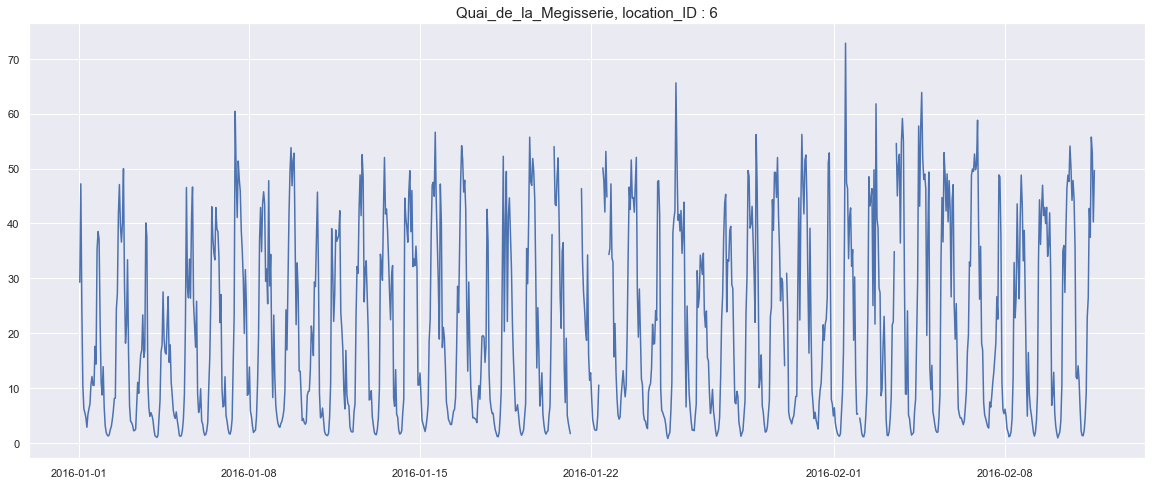

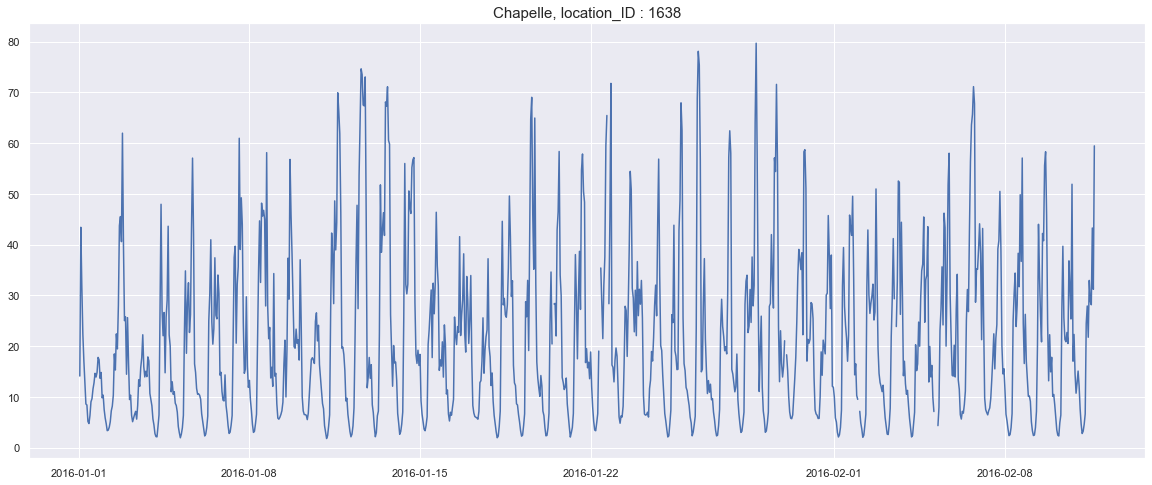

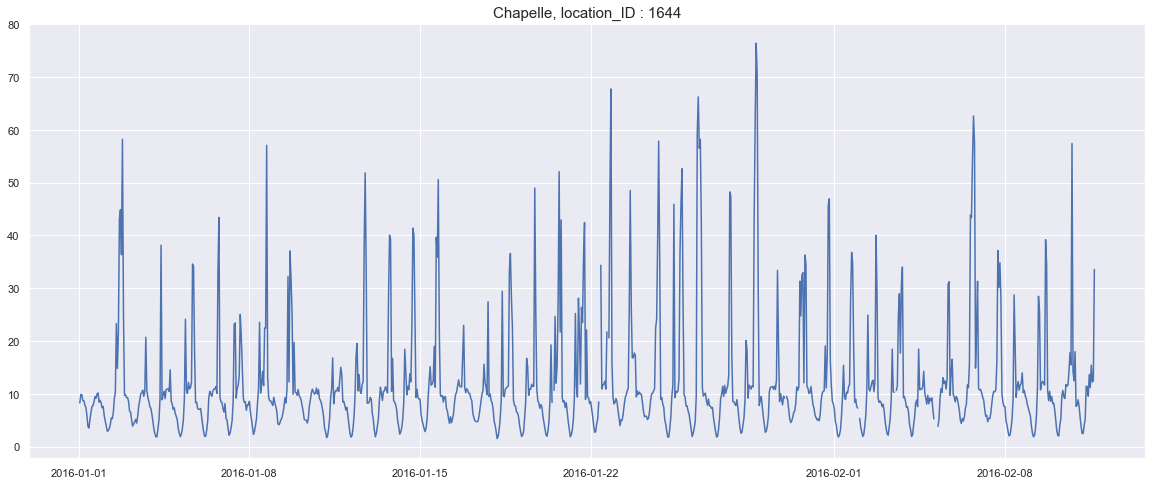

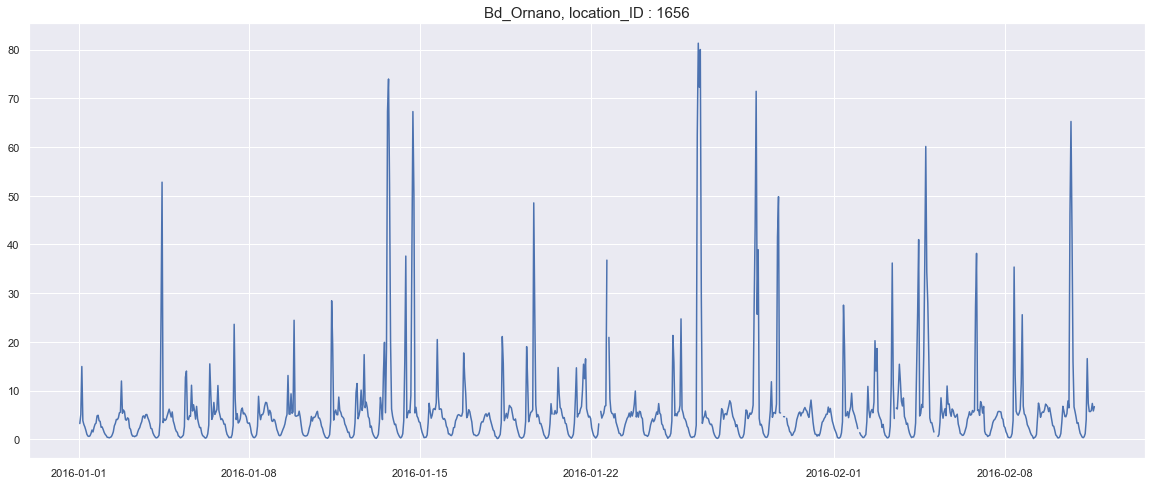

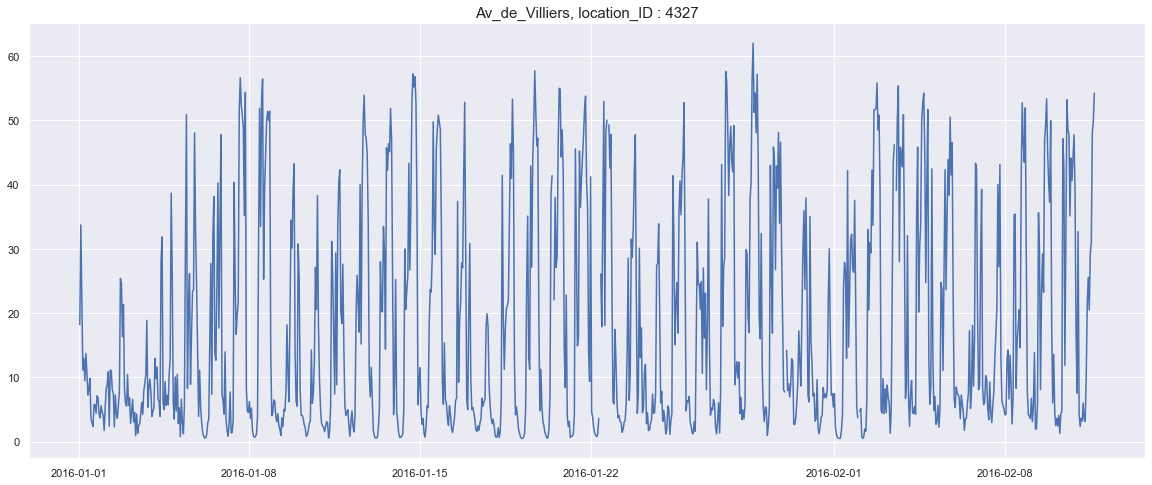

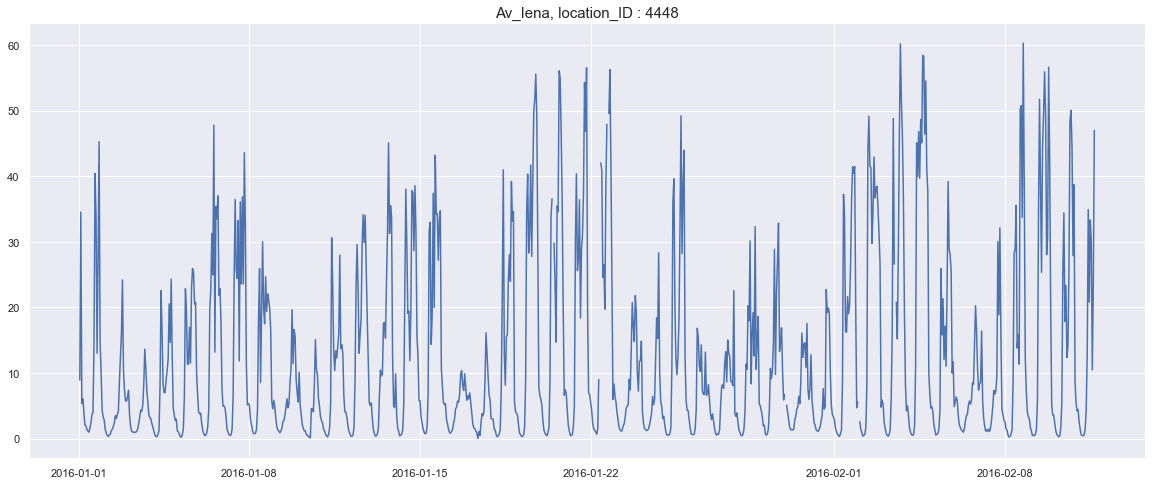

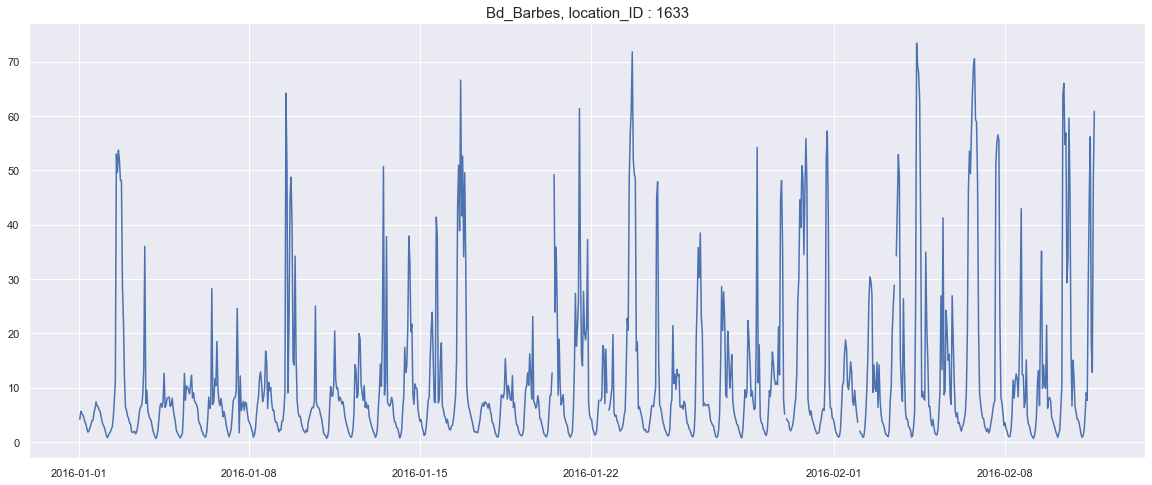

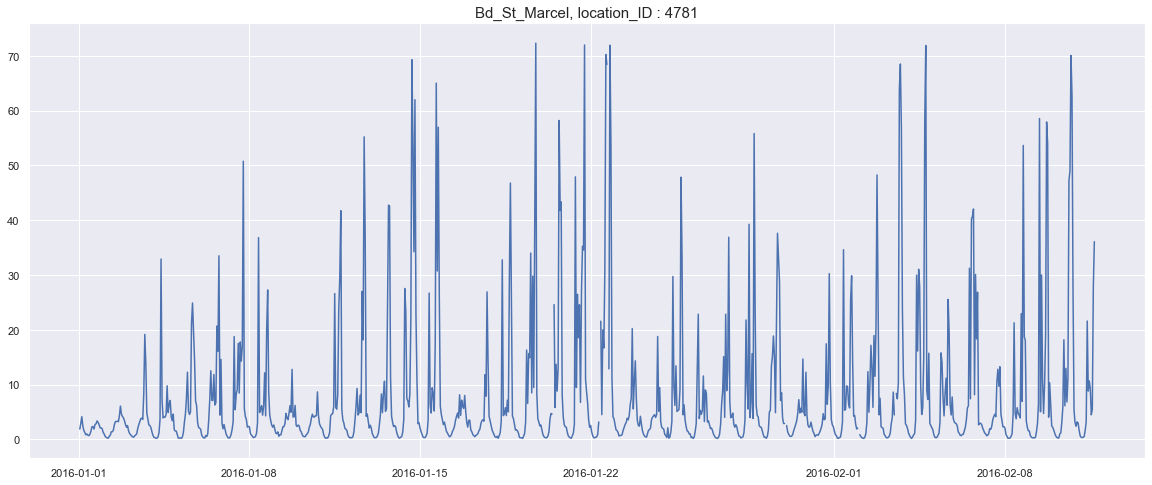

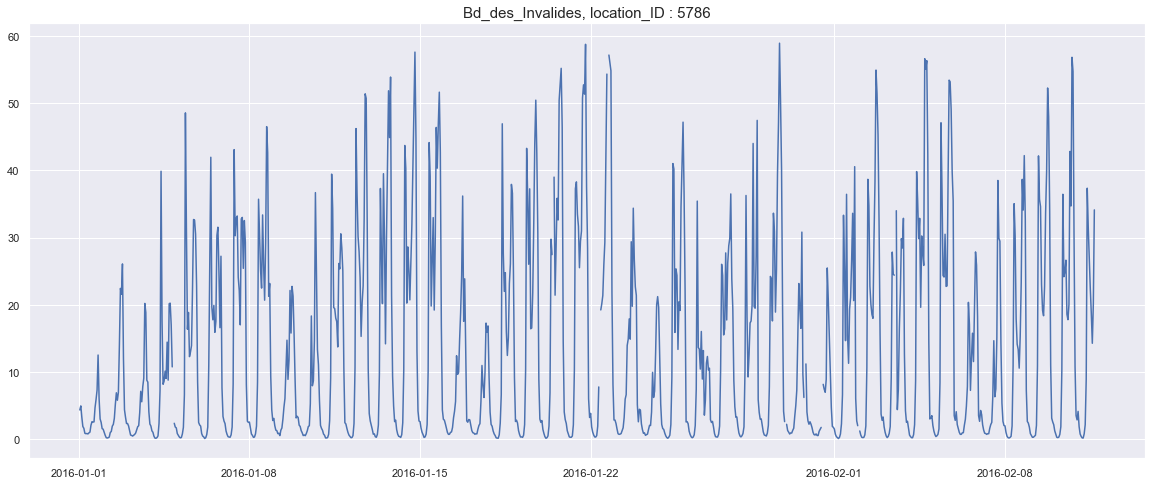

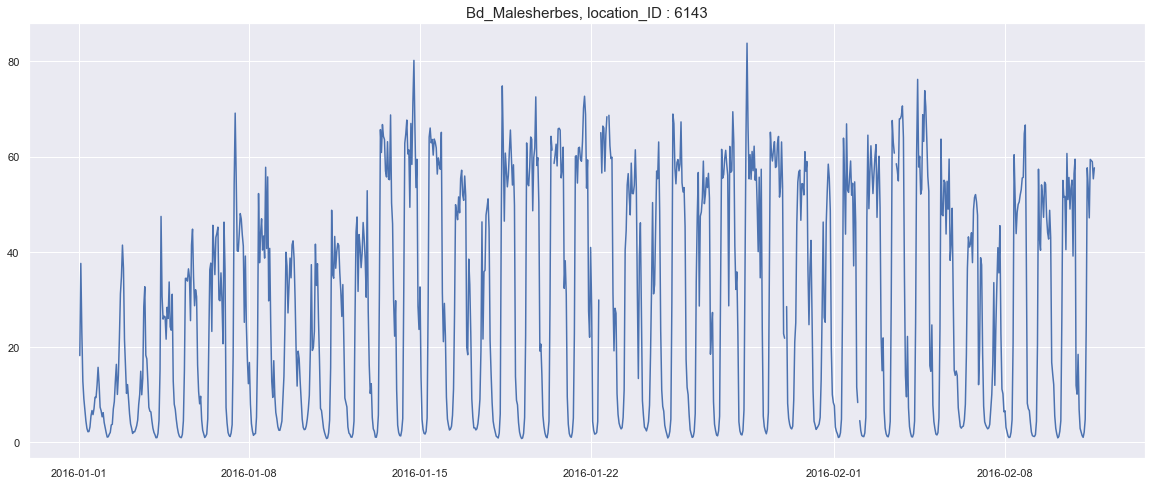

In [894]:
for loc in df["location_ID"].unique()[:10] :
    location=df[df["location_ID"]==loc].set_index("timestamp")
    
    fig,ax=plt.subplots(figsize=(20,8));
    
    text=location["road_name"].iloc[0]+', location_ID : '+ str(location["location_ID"].iloc[0])
    
    ax.set_title(text,fontsize=15)
      
    ax.plot(location["occupation_rate"][:1000])

### Forecasting traffic rates at Boulevard des Invalides

In [895]:
df_rates=df.set_index("timestamp")[["location_ID","occupation_rate"]].pivot(columns="location_ID",values="occupation_rate")
df_rates=df_rates.interpolate(method="time")

In [896]:
df_rates.shape

(26303, 36)

#### Baseline : Naive Forecasting

In [897]:
X=df_rates.drop(5786,axis=1)[1:]
y=df_rates[5786][1:]

In [898]:
## Forecast = value at time t-1
y_pred=df_rates[5786].shift()[1:]

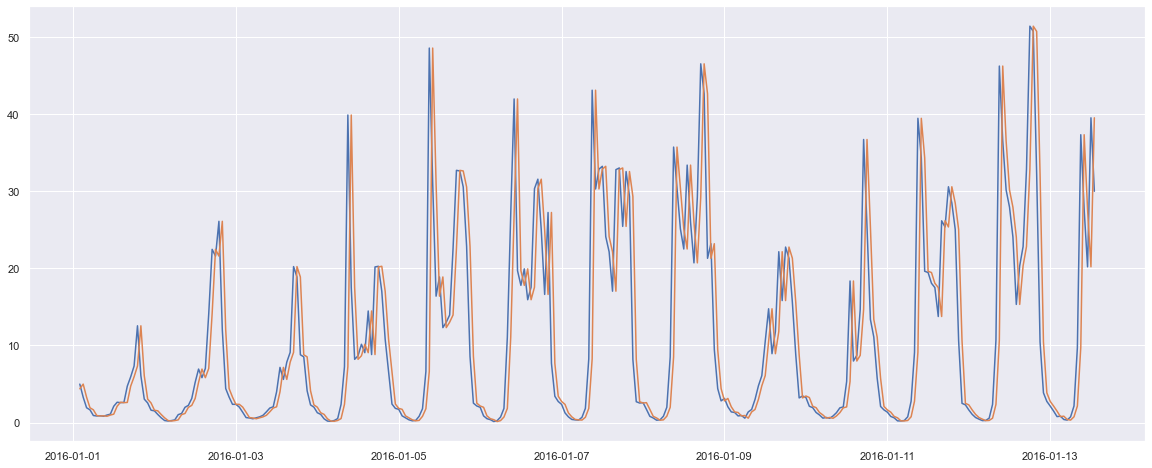

In [899]:
plt.subplots(figsize=(20,8));
plt.plot(y[:300]);
plt.plot(y_pred[:300]);

In [900]:
from sklearn.metrics import mean_absolute_error
error=mean_absolute_error(y[10000:],y_pred[10000:])
print("rooted mean squared error for naive forecasting : ", error)

rooted mean squared error for naive forecasting :  5.334602191142191


In [901]:
from sklearn.metrics import confusion_matrix
confusion_matrix((y_pred[10000:-1]>30)*1,(y[10001:]>30)*1)

array([[10565,  1335],
       [ 1337,  3064]])

In [ ]:
from sklearn.metrics import accuracy_score

#### Linear Regression on other recording stations at time t-1

In [871]:
features=df_rates.corr()[5786].sort_values(ascending=False).index[1:100]

In [872]:
X=df_rates.drop(5786,axis=1)[features][:-1]
y=df_rates[5786].shift(-1)[:-1]

In [876]:
X_train=X[:10000]
X_test=X[10000:]
y_train=y[:10000]
y_test=y[10000:]

In [877]:
from sklearn.linear_model import LinearRegression
lm=LinearRegression()
lm.fit(X_train,y_train)

LinearRegression()

In [878]:
y_pred=lm.predict(X_test)

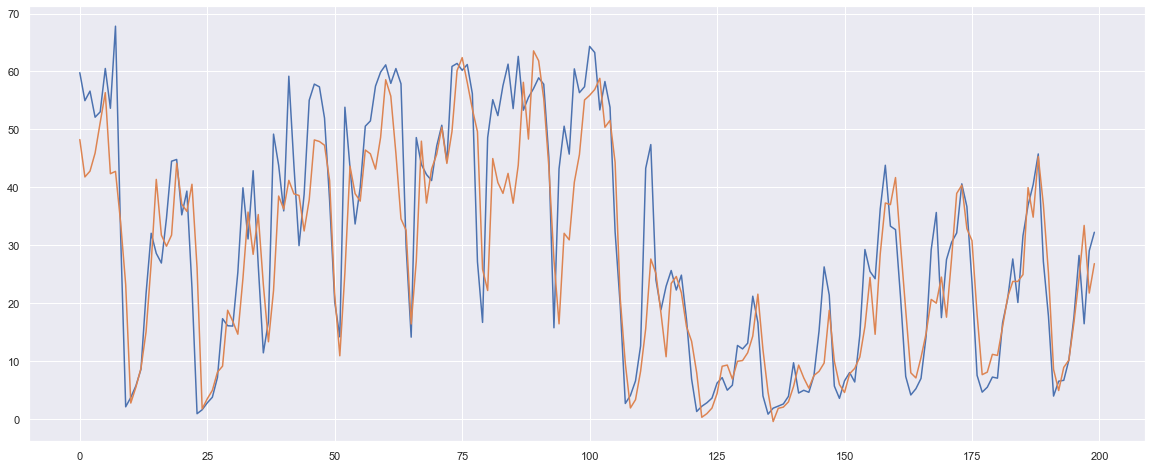

In [879]:
plt.subplots(figsize=(20,8))
plt.plot(y_test.values[:200])
plt.plot(y_pred[:200])

In [880]:
error = mean_absolute_error(y_test,y_pred)
print("rooted mean squared error for simple linear regression ", error)

rooted mean squared error for simple linear regression  8.28011269423784


#### Linear regression on multivariate time series of other stations

In [685]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [686]:
#X=series_to_supervised(np.array(df_rates[[5786]]),7,0).values
X=series_to_supervised(np.array(df_rates.iloc[:,:500]),7,0).values
y=df_rates[5786][7:].values

X_train=X[:20000]
X_test=X[20000:]
y_train=y[:20000]
y_test=y[20000:]

rooted mean squared error for simple linear regression  4.361458626450519


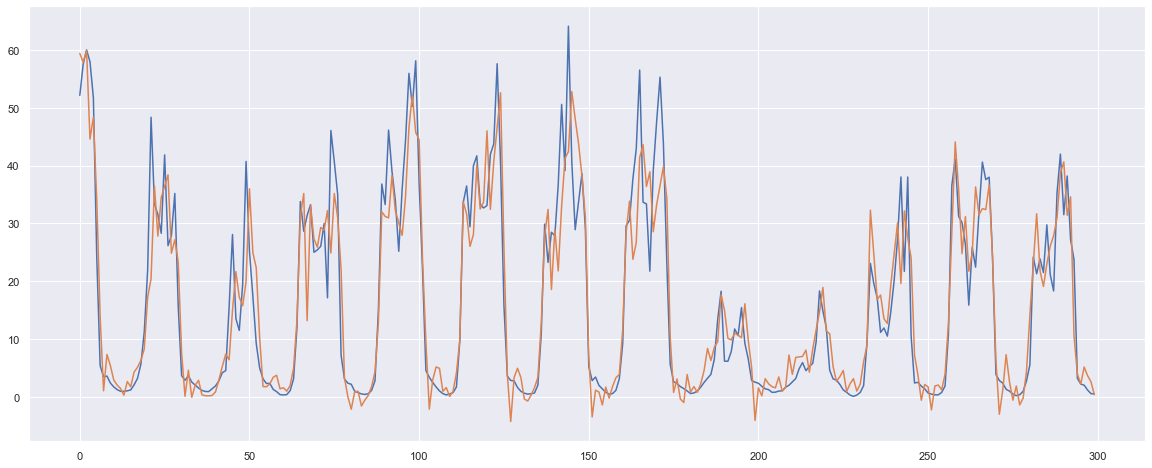

In [687]:
from sklearn.linear_model import LinearRegression
lm=LinearRegression()
lm.fit(X_train,y_train)

y_pred=lm.predict(X_test)

plt.subplots(figsize=(20,8))
plt.plot(y_test[:300])
plt.plot(y_pred[:300])

from sklearn.metrics import mean_absolute_error
error = mean_absolute_error(y_test,y_pred)
print("rooted mean squared error for simple linear regression ", error)

In [689]:
confusion_matrix((y_pred>50)*1,(y_test>50)*1)

array([[5659,  243],
       [ 107,  287]])

#### Deep learning model on multivariate time series of other stations

In [859]:
df_day=df[(df["hour"]>7) & (df["hour"]<22)]

In [860]:
df_rates=df_day.set_index("timestamp")[["location_ID","occupation_rate"]].pivot(columns="location_ID",values="occupation_rate")
df_rates=df_rates.interpolate(method="time")

In [861]:
import tensorflow as tf

In [862]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [863]:
#X=series_to_supervised(np.array(df_rates[[5786]][:-1]),6,0).values
X=series_to_supervised(np.array(df_rates.iloc[:,:]),7,0).values
y=df_rates[5786][7:].values

In [864]:
X.shape

(15337, 252)

In [865]:
y.shape

(15337,)

In [866]:
X_train=X[:10000]
X_test=X[10000:]
y_train=y[:10000]
y_test=y[10000:]

In [867]:
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(10000, 1, 252) (10000,) (5337, 1, 252) (5337,)


In [868]:
import tensorflow as tf

# design network
model = tf.keras.Sequential()

#model.add(tf.keras.layers.LSTM(80, input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(tf.keras.layers.Dense(20,activation="relu"))
model.add(tf.keras.layers.SimpleRNN(20,activation="relu"))
#model.add(tf.keras.layers.Dense(10,activation="relu"))
#model.add(tf.keras.layers.SimpleRNN(3,activation="relu"))
model.add(tf.keras.layers.Dense(1))
#model.add(tf.keras.layers.Dense(2, activation='softmax'))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

#model.compile(loss='mae', optimizer='adam')
model.compile(optimizer='adam', 
              loss='mae')

# fit network
history = model.fit(X_train, y_train, epochs=30, batch_size=30, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Epoch 1/30
334/334 - 1s - loss: 9.7255 - val_loss: 8.7637
Epoch 2/30
334/334 - 1s - loss: 7.9827 - val_loss: 7.6733
Epoch 3/30
334/334 - 1s - loss: 7.4819 - val_loss: 7.2805
Epoch 4/30
334/334 - 1s - loss: 7.1124 - val_loss: 7.0123
Epoch 5/30
334/334 - 1s - loss: 6.8922 - val_loss: 6.8431
Epoch 6/30
334/334 - 1s - loss: 6.6846 - val_loss: 6.7038
Epoch 7/30
334/334 - 1s - loss: 6.4917 - val_loss: 6.6173
Epoch 8/30
334/334 - 1s - loss: 6.3558 - val_loss: 6.4757
Epoch 9/30
334/334 - 1s - loss: 6.2513 - val_loss: 6.3432
Epoch 10/30
334/334 - 1s - loss: 6.1575 - val_loss: 6.3427
Epoch 11/30
334/334 - 1s - loss: 6.0466 - val_loss: 6.2136
Epoch 12/30
334/334 - 1s - loss: 5.9598 - val_loss: 6.1547
Epoch 13/30
334/334 - 1s - loss: 5.8923 - val_loss: 6.1238
Epoch 14/30
334/334 - 1s - loss: 5.8376 - val_loss: 6.0376
Epoch 15/30
334/334 - 1s - loss: 5.7916 - val_loss: 6.0417
Epoch 16/30
334/334 - 1s - loss: 5.7469 - val_loss: 5.9476
Epoch 17/30
334/334 - 1s - loss: 5.6859 - val_loss: 5.9299
Epoch 

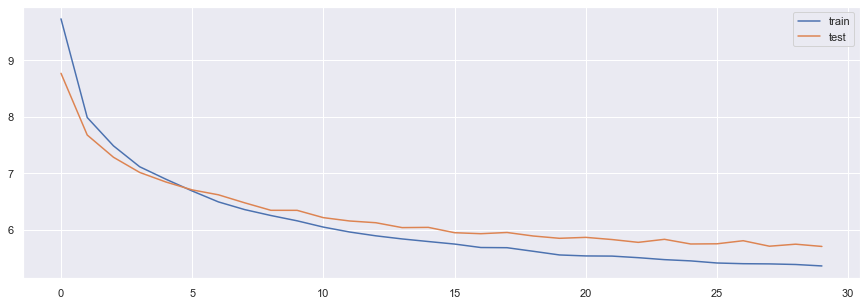

In [869]:
# plot history
plt.subplots(figsize=(15,5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

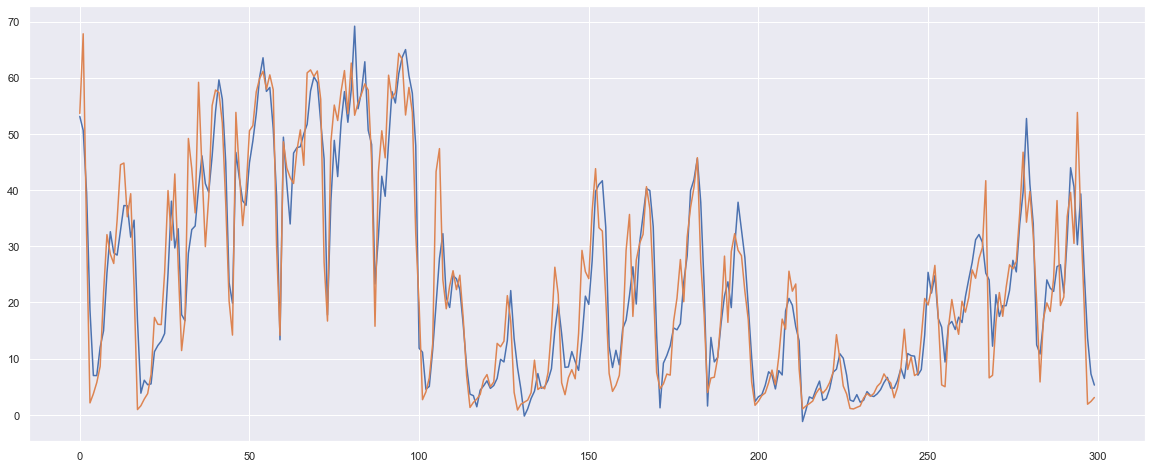

In [870]:
#Plot forecast vs test
forecast = model.predict(X_test).reshape(-1)
plt.subplots(figsize=(20,8))
plt.plot(forecast[:300])
plt.plot(y_test[:300])

In [832]:
confusion_matrix((forecast>30)*1,(y_test>30)*1)

array([[3228,  276],
       [ 370, 2560]])

In [795]:
df_day=df[(df["hour"]>6) & (df["hour"]<22)]

In [796]:
df_day

,timestamp,date,year,week,weekday,hour,location_ID,road_ID,road_name,longitude,latitude,road_status,trafic_status,flow_rate,occupation_rate
216,2016-01-01 07:00:00,2016-01-01,2016,53,4,7,4497,199,Av_Victor_Hugo,2.282130,48.868382,3.0,1.0,47.0,1.11945
217,2016-01-01 07:00:00,2016-01-01,2016,53,4,7,1638,372,Chapelle,2.360027,48.890650,3.0,1.0,792.0,8.58611
218,2016-01-01 07:00:00,2016-01-01,2016,53,4,7,1644,372,Chapelle,2.359535,48.894284,3.0,1.0,792.0,7.43222
219,2016-01-01 07:00:00,2016-01-01,2016,53,4,7,1656,291,Bd_Ornano,2.345394,48.896873,3.0,1.0,509.0,1.83444
220,2016-01-01 07:00:00,2016-01-01,2016,53,4,7,4327,216,Av_de_Villiers,2.300295,48.884613,3.0,1.0,NaN,13.71280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946831,2018-12-31 21:00:00,2018-12-31,2018,1,0,21,1565,280,Bd_Magenta,2.353647,48.878901,3.0,3.0,748.0,43.55220
946832,2018-12-31 21:00:00,2018-12-31,2018,1,0,21,1567,280,Bd_Magenta,2.352767,48.879873,3.0,2.0,748.0,24.75110
946833,2018-12-31 21:00:00,2018-12-31,2018,1,0,21,1569,280,Bd_Magenta,2.351498,48.881255,3.0,3.0,720.0,34.27830
946834,2018-12-31 21:00:00,2018-12-31,2018,1,0,21,1572,280,Bd_Magenta,2.349562,48.883735,3.0,3.0,586.0,33.66170


In [791]:
2197/365

6.019178082191781